# Decision trees

A [decision tree](https://en.wikipedia.org/wiki/Decision_tree_learning) can be thought of as a sequence of **hierarchical if-else statements** that test feature values to predict a class.


In this notebook we will explore the use of the classification module in PySpark that implements Decision Trees classifiers. The [ml classification module](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.classification) in PySpark basically comes with two classes that we will use in the Notebook, namely, the *pyspark.ml.classification.DecisionTreeClassifier* and the *pyspark.ml.classification.DecisionTreeClassifierModel*.

Before using pyspark.ml we are going to use [scikit-learn](https://scikit-learn.org/stable/) for Decision Trees. This first example will allow us to understand some of the parameters in a decision tree. In the second example, we will see how those parameters are defined in PySpark or what relationships.


## Example with scikit-learn

We will build a classifier that will be able to detect spam from the text in an email. The dataset that we will use is from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php), where UCI stands for University of California Irvine. The UCI repository is and has been a valuable resource in Machine Learning. It contains datasets for classification, regression, clustering and several other machine learning problems. These datasets are open source and they have been uploaded by contributors of many research articles. 

The particular dataset that we will use wil be referred to is the [Spambase Dataset](http://archive.ics.uci.edu/ml/datasets/Spambase). A detailed description is the previous link. The dataset contains 57 features related to word frequency, character frequency, and others related to capital letters. The description of the features and labels in the dataset is available [here](http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names). The output label indicated whether an email was considered 'ham' or 'spam', so it is a binary label. 

We will use Decision tree as our predictive model. But first, we upload the data and the names of the columns

In [1]:
import pandas as pd
import numpy as np
spam_data = pd.read_csv('./files/spambase.data')
spam_names = [spam_names.rstrip('\n') for spam_names in open('./files/spambase.data.names')]
number_names = np.shape(spam_names)[0]
for i in range(number_names):
    local = spam_names[i]
    colon_pos = local.find(':')
    spam_names[i] = local[:colon_pos]
spam_data.columns = spam_names
X = spam_data.iloc[:, 0:57]
y = spam_data.iloc[:, 57]

We now use the whole dataset to build a decision tree classifier. 

In [2]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf = clf.fit(X, y)

In [3]:
clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

To visualize the tree, we can use the [Graphviz](http://www.graphviz.org/) package and use the exporter [export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz). First, we need to install the package. An easy way to do it is to use `conda`

`conda install python-graphviz`

We will export the tree as a pdf file spam.pdf

In [4]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("spam")

'spam.pdf'

We can use the [export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn.tree.export_graphviz) to customize several aspects of the tree. For example, if you look at the .pdf file generated, the names of the features are assigned by default by refering to the column index in `X`. It is possible to assign the names of the features directly. Likewise for the labels `y`. 

In [5]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=spam_names[0:57],  
                      class_names=spam_names[57],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  

Instead of printing a new .pdf file, we can render the graph inline

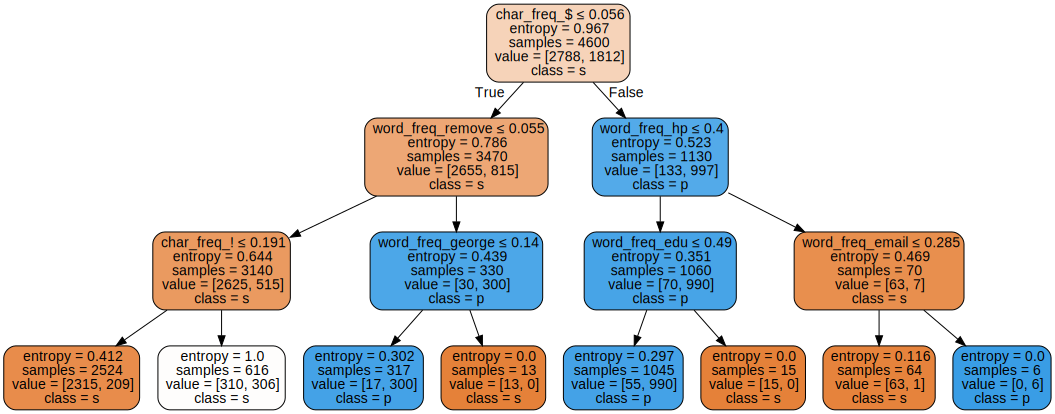

In [6]:
graph

One could quickly use the tree generated for the purposes of [feature selection](https://en.wikipedia.org/wiki/Feature_selection). Feature selection is a whole research area in machine learning with a very practical purpose: being able to identify which features are more relevant in a prediction problem. In modern big data applications, the amount of features generated is huge. For example, one could extract thousands of millions of features from a genome sequence that maps to a particular medical disorder. Finding which features are more relevant for correctly classifying the disorder could lead to breakthroughs in medicine. 

Relevant features can be identified starting from the top level of the tree and going down to the leaf nodes. For example, one can argue that the most important feature is the one used in the root node (e.g. char_freq_$ for the Spambase dataset) since it has the highest entropy.    

## Evaluating the prediction ability of a decision tree classifier

We will now evaluate the predictive ability of the decision tree classifier on a subset of the Spam dataset. The Decision Tree has several tunable parameters, including, the criterion or impurity measure (criterion) and the maximum depth of the tree (max_depth). A complete list of parameters for the DecisionTreeClassifier implemented in scikit-learn can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

We will create a simple Grid Search for crosvalidating the best parameters for our model. 

In [7]:
# We first split the data into a train and a test set. 
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
indexes = list(ss.split(X, y))
train_set  = indexes[0][0]
test_set  = indexes[0][1]
Xtrain = X.iloc[train_set, :]
ytrain = y.iloc[train_set]
Xtest = X.iloc[test_set, :]
ytest = y.iloc[test_set]

We now create a Grid search for the parameters criterion and max_depth and we use the training data to find the best parameters

In [8]:
from sklearn.model_selection import GridSearchCV # For model selection
criterion_opts = np.array(['entropy', 'gini'])
max_depth_opts = [3, 5, 10, 15]
param_grid = dict(criterion = criterion_opts, max_depth = max_depth_opts)
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, cv=cv, scoring='accuracy')
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': array(['entropy', 'gini'], dtype='<U7'), 'max_depth': [3, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

We can see now which ones were the best parameters.

In [9]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 15}

We then train a new decision tree using those parameters and then evaluate the model on the test set.

In [10]:
clf = tree.DecisionTreeClassifier(criterion=grid.best_params_["criterion"],max_depth=grid.best_params_["max_depth"])
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)    

We now evaluate the accuracy and the receiving operating curve

In [11]:
from sklearn.metrics import accuracy_score # Accuracy score
#from sklearn.metrics import roc_auc_score  # Area under the 
accuracy = accuracy_score(ytest, ypred)
#auc = roc_auc_s|core(ytest, ypred)
print(accuracy) 

0.908695652173913


### Distribution of the labels

Let us look at the distribution of the instances for class in the original dataset and in the training data. 

>**Warning for MAC OS users** As of today, the current installation of `graphviz` **may** put its own version of freetype into the default python runtime library path. However, matplotlib needs a different version of the same library. The fix is explained in [this entry of stackoverflow](https://stackoverflow.com/questions/28028786/matplotlib-error-libfreetype-6-dylib). 

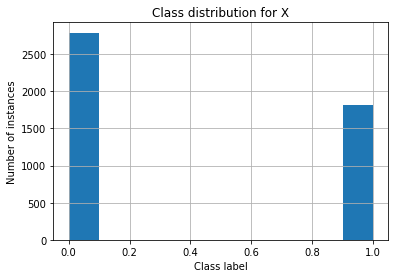

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
y.hist()
plt.ylabel('Number of instances')
plt.xlabel('Class label')
plt.title('Class distribution for X')
plt.show()

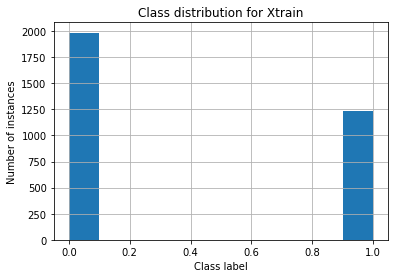

In [13]:
ytrain.hist()
plt.ylabel('Number of instances')
plt.xlabel('Class label')
plt.title('Class distribution for Xtrain')
plt.show()

Notice that the numbers of data observations per class are different. We usually refer to this kind of problems as "imbalanced". Bear in mind that when creating your training data, you need to account for this imbalance and be aware against misleading results. For example, accuracy is probably not a good metric to measure performance in these problems. Say you have a binary classification problem for which your test data consists of 100 instances. From those, 99 instances belong to class 1, say 'ham', and 1 instance belong to class 2, say 'spam'. When you test your classifier on these instances, you could have a classifier that only is able to predict class 1 correctly, but elements of class 2 are predicted incorrectly. If you apply this classifier to your test data, you would get 99% accuracy. Looking at this percentage out of context and saying that you have produced a highly realible classifier is completely wrong since your classifier only learned to correctly classify instances in class 1. The problem gets worse if your test set is large, say 100,000 instances, 99,000 are correctly predicted for class 1 and 1,000 are incorrectly predicted for class 2. Even when the classifier fails in correctly predicted 1,000 instances from class 2, the accuracy of this classifier would be 99%.

There are different [strategies for balancing a dataset](https://books.google.co.uk/books/about/Imbalanced_Learning.html?id=YqQJngEACAAJ&redir_esc=y) but if for some reason you are not able to balance it, it is important to be aware of these issues. Two stategies to use are: i) instead of simply splitting the data blindly, split the data accounting for the imbalance. sckiti-learn offers the class [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) for this. Using stratified sampling is particuarly important for regression problems. ii) do not trust "accuracy" as the sole metric to measure performance. Other classification metrics more suitable for imbalanced problems include [recall, precision, F1](https://en.wikipedia.org/wiki/Precision_and_recall), and [area under the curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). 

### Question 1

Repeat the spam prediction problem above but instead of splitting the data using ShuffleSplit, use StratifiedShuffleSplit. Do you notice any difference in the accuracy? Also, use a performance measure that takes into account imbalanced data. Do you see any different between this new performance measure when spliting with StratifiedShuffleSplit and when sppliting using ShuffleSplit?

## DecisionTreeClassifier in PySpark

There are several challenges when implementing decision trees in a distributed setting, particularly when we want to use [commodity hardware](https://en.wikipedia.org/wiki/Commodity_computing). A very popular implementation is known as [PLANET: Massively Parallel Learning of Tree Ensembles with MapReduce](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36296.pdf). PLANET allows an efficient implementation of decision trees at large scale purely using map() and reduce() operations, suitable for a Hadoop cluster. Although the Decision Tree implementation in [Apache Spark borrows some of the ideas from PLANET](http://jmlr.org/papers/volume17/15-237/15-237.pdf), it also introduces additional tricks that exploit the well-known advantages of Apache Spark, in memory computing, overall. The Apache Spark implementation of the DecisionTree classifier may not be as flexible as the scikit-learn one (bear in mind they were designed under a different sets of restrictions), but it still allows the use of such a powerful machine learning model at large scale.

You can find more technical details on the implementation of Decision Trees in Apache Spark in the youtube video [Scalable Decision Trees in Spark MLlib](https://www.youtube.com/watch?v=N453EV5gHRA&t=10m30s) by Manish Amde and the youtube video [Decision Trees on Spark](https://www.youtube.com/watch?v=3WS9OK3EXVA) by Joseph Bradley. These technical details are also reviewed in a [blog post on decision trees](https://databricks.com/blog/2014/09/29/scalable-decision-trees-in-mllib.html) and another [blog post on random forests](https://databricks.com/blog/2015/01/21/random-forests-and-boosting-in-mllib.html). 

We start by creating a <tt>SparkSession</tt> (unless you are running in a pyspark shell)

In [14]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import numpy as np
spark = SparkSession.builder.master("local[2]").appName("COM6012 Decision Trees").getOrCreate()

We now load the dataset and load the names of the features and label that we will use to create the schema for the dataframe. We also cache the dataframe since we are going to perform several operations to rawdata inside a loop.

In [15]:
rawdata = spark.read.csv('./files/spambase.data')
rawdata.cache()
ncolumns = len(rawdata.columns)
spam_names = [spam_names.rstrip('\n') for spam_names in open('./files/spambase.data.names')]
number_names = np.shape(spam_names)[0]
for i in range(number_names):
    local = spam_names[i]
    colon_pos = local.find(':')
    spam_names[i] = local[:colon_pos]

We use the [<tt>withColumnRenamed</tt>](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumnRenamed) method for the dataframe to rename the columns using the more familiar names for the features.

In [16]:
schemaNames = rawdata.schema.names
spam_names[ncolumns-1] = 'labels'
for i in range(ncolumns):
    rawdata = rawdata.withColumnRenamed(schemaNames[i], spam_names[i])

Perhaps one of the most important operations when doing data analytics in Apache Spark consists in preprocessing the dataset so that it can be analysed using the MLlib package. In the case of supervised learning, classification or regression, we want the data into a column of type `Double` for the label and a column of type `SparseVector` or `DenseVector` for the features. 

We import the <tt>Double</tt> type from pyspark.sql.types, use the [<tt>withColumn</tt>](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html?highlight=withcolumn#pyspark.sql.DataFrame.withColumn) method for the dataframe and `cast()` the column to DoubleType.

In [17]:
from pyspark.sql.types import DoubleType
for i in range(ncolumns):
    rawdata = rawdata.withColumn(spam_names[i], rawdata[spam_names[i]].cast(DoubleType()))

In [18]:
rawdata.printSchema()

root
 |-- word_freq_make: double (nullable = true)
 |-- word_freq_address: double (nullable = true)
 |-- word_freq_all: double (nullable = true)
 |-- word_freq_3d: double (nullable = true)
 |-- word_freq_our: double (nullable = true)
 |-- word_freq_over: double (nullable = true)
 |-- word_freq_remove: double (nullable = true)
 |-- word_freq_internet: double (nullable = true)
 |-- word_freq_order: double (nullable = true)
 |-- word_freq_mail: double (nullable = true)
 |-- word_freq_receive: double (nullable = true)
 |-- word_freq_will: double (nullable = true)
 |-- word_freq_people: double (nullable = true)
 |-- word_freq_report: double (nullable = true)
 |-- word_freq_addresses: double (nullable = true)
 |-- word_freq_free: double (nullable = true)
 |-- word_freq_business: double (nullable = true)
 |-- word_freq_email: double (nullable = true)
 |-- word_freq_you: double (nullable = true)
 |-- word_freq_credit: double (nullable = true)
 |-- word_freq_your: double (nullable = true)
 |-- 

We have now a dataframe that contains several columns corresponding to the features and the last column corresponding to the labels. We use the [<tt>VectorAssembler</tt>](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=vectorassembler#pyspark.ml.feature.VectorAssembler) tool to concatenate all the features in a vector.

In [19]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = spam_names[0:ncolumns-1], outputCol = 'features') 
raw_plus_vector = assembler.transform(rawdata)

<tt>raw_plus_vector</tt> is now a dataframe with an additional column for the feature vectors. We create our final dataframe, that we call data, by selecting the appropriate columns from <tt>raw_plus_vector</tt> 

In [20]:
data = raw_plus_vector.select('features','labels')

In [21]:
data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- labels: double (nullable = true)



The pyspark code above was all for preprocessing the data. We can now start the machine learning analysis by creating the training and test set and then designing the DecisionTreeClassifier using the training data.

In [22]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], 42)

The [DecisionTreeClassifier](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=decisiontreeclassifier#pyspark.ml.classification.DecisionTreeClassifier) implemented in PySpark has several parameters to tune. Some of them are

> **maxDepth**: it corresponds to the maximum depth of the tree. The default is 5.<p>
**maxBins**: it determines how many bins should be created from continuous features. The default is 32.<p>
    **impurity**: it is the metric used to compute information gain. The options are "gini" or "entropy". The default is "gini".<p>
        **minInfoGain**: it determines the minimum information gain that will be used for a split. The default is zero.


In [23]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="labels", featuresCol="features", maxDepth=10, impurity='entropy')
model = dt.fit(trainingData)
predictions = model.transform(testData)

We finally use the [MulticlassClassificationEvaluator](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=multiclassclassificationevaluator#pyspark.ml.evaluation.MulticlassClassificationEvaluator) tool to assess the accuracy on the test set.

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator\
      (labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g " % accuracy)

Accuracy = 0.92371 


The individual importance of the features can be obtained using [featureImportances](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=featureimportances#pyspark.ml.classification.DecisionTreeClassificationModel.featureImportances). We can recover the values of importance and the indexes of the vector where these values are different from zero using values and indices

In [25]:
fi = model.featureImportances

In [26]:
imp_feat = np.zeros(ncolumns-1)
imp_feat[fi.indices] = fi.values

Let us plot the relative importances

<Container object of 57 artists>

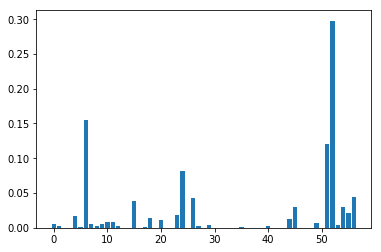

In [27]:
x = np.arange(ncolumns-1)
plt.bar(x, imp_feat)

The feature with the highest importance is 

In [28]:
spam_names[np.argmax(imp_feat)]

'char_freq_$'

We can visualise the DecisionTree in the form of *if-then-else* statements.

In [29]:
print(model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_7ba0be1cca20) of depth 10 with 185 nodes
  If (feature 52 <= 0.0525)
   If (feature 6 <= 0.055)
    If (feature 51 <= 0.3805)
     If (feature 26 <= 0.005)
      If (feature 15 <= 0.025)
       If (feature 23 <= 0.01)
        If (feature 24 <= 0.01)
         If (feature 56 <= 28.5)
          If (feature 7 <= 0.005)
           Predict: 0.0
          Else (feature 7 > 0.005)
           If (feature 20 <= 0.01)
            Predict: 0.0
           Else (feature 20 > 0.01)
            Predict: 1.0
         Else (feature 56 > 28.5)
          If (feature 4 <= 1.835)
           Predict: 0.0
          Else (feature 4 > 1.835)
           If (feature 35 <= 0.005)
            Predict: 1.0
           Else (feature 35 > 0.005)
            Predict: 0.0
        Else (feature 24 > 0.01)
         If (feature 10 <= 0.295)
          Predict: 0.0
         Else (feature 10 > 0.295)
          If (feature 20 <= 0.515)
           Predict: 0.0
         

A better visualisation can be obtained by using, for example, [spark-tree-plotting](https://github.com/julioasotodv/spark-tree-plotting). The trick is to convert the spark tree to a JSON format. Once you have the JSON format, you can visualise it using [D3](https://d3js.org/) or you can transform from JSON to DOT and use graphviz as we did in scickit-learn. Are you able to generate a nicer visualisation of the tree?

### Question 2

Modify the program above to run the decision tree as part of a pipeline (see [Notebook 2](https://github.com/haipinglu/ScalableML/blob/master/Lab%202%20-%20RDD%2C%20DataFrame%2C%20ML%20pipeline%2C%20and%20parallelization.ipynb) for a refresher on pipelines). The pipeline model can be used to find the best set of parameters using cross validation. An example of a cross-validator can be found [here](http://spark.apache.org/docs/2.4.0/ml-tuning.html#cross-validation). In your case, make <tt>paramGrid</tt> contains different values for <tt>maxDepth</tt>, <tt>maxBins</tt> and <tt>impurity</tt> and find the best parameters and associated test error.

### Question 3 

Make the decision tree code a standalone program to run on HPC (see [Notebook 1](https://github.com/haipinglu/ScalableML/blob/master/Lab%201%20-%20Introduction%20to%20Spark%20and%20HPC.ipynb) for a refresher on how to run standalone programs in HPC or using the Notebook through Jupyter Hub).

### Question 4 (optional)

Create a decision tree classifier that runs on the [default of credit cards](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) dataset. Several of the features in this dataset are categorical. Use the tools provided by PySpark (pyspark.ml.feature) for treating categorical variables. 

Note also that this dataset has a different format to the Spambase dataset above - you will need to convert from XLS format to, say, CSV, before using the data. You can use any available tool for this: for example, Excell has an export option, or there is a command line tool <tt>xls2csv</tt> available on Linux.